# Objective - Prepare solution to build ticketing system 



In [1]:
import pandas as pd
import json
import numpy as np
import re
import spacy,nltk
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import NMF
import pickle

# Loading the data

In [2]:
with open('Client_data.json') as f:  
      data = json.load(f)
df=pd.json_normalize(data)

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


# Data prepration and Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [4]:
df.describe

<bound method NDFrame.describe of                     _index      _type      _id  _score   _source.tags  \
0      complaint-public-v2  complaint  3211475     0.0           None   
1      complaint-public-v2  complaint  3229299     0.0  Servicemember   
2      complaint-public-v2  complaint  3199379     0.0           None   
3      complaint-public-v2  complaint  2673060     0.0           None   
4      complaint-public-v2  complaint  3203545     0.0           None   
...                    ...        ...      ...     ...            ...   
78308  complaint-public-v2  complaint  3105617     0.0           None   
78309  complaint-public-v2  complaint  3091984     0.0           None   
78310  complaint-public-v2  complaint  3133355     0.0           None   
78311  complaint-public-v2  complaint  3110963     0.0           None   
78312  complaint-public-v2  complaint  2001189     0.0           None   

      _source.zip_code _source.complaint_id  \
0                90301              321147

In [5]:
df.shape

(78313, 22)

In [6]:
df.isnull().sum()

_index                                   0
_type                                    0
_id                                      0
_score                                   0
_source.tags                         67413
_source.zip_code                      6757
_source.complaint_id                     0
_source.issue                            0
_source.date_received                    0
_source.state                         1991
_source.consumer_disputed                0
_source.product                          0
_source.company_response                 0
_source.company                          0
_source.submitted_via                    0
_source.date_sent_to_company             0
_source.company_public_response      78309
_source.sub_product                  10571
_source.timely                           0
_source.complaint_what_happened          0
_source.sub_issue                    46297
_source.consumer_consent_provided     1008
dtype: int64

### Updating column names 

In [7]:
df.columns = ['index', 'type', 'id', 'score', 'tags', 'zip_code','complaint_id', 'issue', 'date_received',
       'state', 'consumer_disputed', 'product','company_response', 'company', 'submitted_via',
       'date_sent_to_company', 'company_public_response','sub_product', 'timely',
       'complaint_what_happened', 'sub_issue','consumer_consent_provided']

In [8]:
df[df['complaint_what_happened'] == ''].index

Int64Index([    0,     3,     4,     5,     6,     7,     8,     9,    12,
               13,
            ...
            78292, 78298, 78299, 78300, 78302, 78304, 78305, 78306, 78307,
            78308],
           dtype='int64', length=57241)

### Replacing blank spaces with NaN 

In [9]:
df[df.loc[:, 'complaint_what_happened'] == ''] = np.nan

### Removing the rows which contains null values

In [10]:
df = df[df['complaint_what_happened'].notna()]

In [11]:
df.shape

(21072, 22)

In [12]:
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)

C:\Users\shubham_soni3\AppData\Local\Temp\ipykernel_24156\1429438214.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)


### Removing all the stopwords  

In [16]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
cdf =  pd.DataFrame(df['complaint_what_happened'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)])))

### Function for data cleaning

In [17]:
def clean_text(sent):
    sent = sent.lower() # Text to lowercase
    pattern = '[^\w\s]' # Removing punctuation
    sent = re.sub(pattern, '', sent) 
    pattern = '\w*\d\w*'
    sent = re.sub(pattern, '', sent) 
    return sent

In [19]:
cdf = pd.DataFrame(cdf['complaint_what_happened'].apply(clean_text))

In [20]:
cdf

,complaint_what_happened
1,good morning name xxxx xxxx i appreciate could...
2,i upgraded xxxx xxxx card told agent upgrade ...
10,chase card reported however fraudulent applic...
11,on trying book xxxx xxxx ticket i came across...
14,grand son give check deposit chase account fu...
...,...
78303,after chase card customer well decade offered ...
78309,on wednesday xxxxxxxx i called chas xxxx xxxx ...
78310,i familiar xxxx pay understand great risk prov...
78311,i flawless credit yrs ive chase credit cards ...


### Removing all the xxxx... text from the rows

In [21]:
cdf['complaint_what_happened'] = cdf['complaint_what_happened'].str.replace('xxxx','') #removing xxxxx 

In [22]:
cdf

,complaint_what_happened
1,good morning name i appreciate could help pu...
2,i upgraded card told agent upgrade annivers...
10,chase card reported however fraudulent applic...
11,on trying book ticket i came across offer ...
14,grand son give check deposit chase account fu...
...,...
78303,after chase card customer well decade offered ...
78309,on wednesday i called chas visa credit card...
78310,i familiar pay understand great risk provides...
78311,i flawless credit yrs ive chase credit cards ...


In [23]:
nlp = spacy.load('en_core_web_sm') 

### Function for Lemmitization

In [24]:
def lemmmatizing_text(text):
    sent = []
    doc = nlp(text)
    for token in doc:
        sent.append(token.lemma_)
    return " ".join(sent)

In [25]:
#cdf = cdf.sample(2000)

In [26]:
cdf['lemmatized_complaint'] = cdf['complaint_what_happened'].apply(lemmmatizing_text)

In [27]:
cdf

,complaint_what_happened,lemmatized_complaint
1,good morning name i appreciate could help pu...,good morning name I appreciate could help p...
2,i upgraded card told agent upgrade annivers...,I upgrade card tell agent upgrade anniver...
10,chase card reported however fraudulent applic...,chase card report however fraudulent applica...
11,on trying book ticket i came across offer ...,on try book ticket I come across offer ...
14,grand son give check deposit chase account fu...,grand son give check deposit chase account f...
...,...,...
78303,after chase card customer well decade offered ...,after chase card customer well decade offer mu...
78309,on wednesday i called chas visa credit card...,on wednesday I call chas visa credit card...
78310,i familiar pay understand great risk provides...,I familiar pay understand great risk provide...
78311,i flawless credit yrs ive chase credit cards ...,I flawless credit yr I ve chase credit card ...


# Feature Extraction

### Applying TF-IDF Vectorizer

In [28]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.95, stop_words='english')

In [29]:
dm = tfidf.fit_transform(cdf['lemmatized_complaint'])

# Topic Modelling using NMF

In [30]:
num_topics = 5

nmf_model = NMF(n_components=num_topics, random_state=40)
nmf_model.fit(dm)
H = nmf_model.components_ 

C:\Users\shubham_soni3\Anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


### Printing top 10 words from each topic 

In [31]:
words = np.array(tfidf.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 10)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(10)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:10]
    topic_words.iloc[i] = words[ix]

topic_words

C:\Users\shubham_soni3\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10
Topic 1,account,check,bank,chase,money,deposit,fund,close,tell,open
Topic 2,credit,card,report,inquiry,chase,hard,account,remove,apply,score
Topic 3,loan,mortgage,chase,home,modification,property,letter,send,year,request
Topic 4,charge,card,chase,dispute,transaction,purchase,fee,merchant,refund,claim
Topic 5,payment,late,pay,make,balance,fee,month,statement,monthly,day


In [32]:
topic_results = nmf_model.transform(dm)

In [33]:
cdf['Topic'] = topic_results.argmax(axis=1)

In [34]:
cdf

,complaint_what_happened,lemmatized_complaint,Topic
1,good morning name i appreciate could help pu...,good morning name I appreciate could help p...,2
2,i upgraded card told agent upgrade annivers...,I upgrade card tell agent upgrade anniver...,3
10,chase card reported however fraudulent applic...,chase card report however fraudulent applica...,1
11,on trying book ticket i came across offer ...,on try book ticket I come across offer ...,1
14,grand son give check deposit chase account fu...,grand son give check deposit chase account f...,0
...,...,...,...
78303,after chase card customer well decade offered ...,after chase card customer well decade offer mu...,3
78309,on wednesday i called chas visa credit card...,on wednesday I call chas visa credit card...,3
78310,i familiar pay understand great risk provides...,I familiar pay understand great risk provide...,3
78311,i flawless credit yrs ive chase credit cards ...,I flawless credit yr I ve chase credit card ...,4


### Creating dictionary of category names 
 

In [35]:
Topic_names = {0:"Banking services", 1:"Card", 2:"Others",3:"Fraudalent reporting", 4:"Loans"}

cdf['Topic'] = cdf['Topic'].map(Topic_names)

In [36]:
cdf

,complaint_what_happened,lemmatized_complaint,Topic
1,good morning name i appreciate could help pu...,good morning name I appreciate could help p...,Others
2,i upgraded card told agent upgrade annivers...,I upgrade card tell agent upgrade anniver...,Fraudalent reporting
10,chase card reported however fraudulent applic...,chase card report however fraudulent applica...,Card
11,on trying book ticket i came across offer ...,on try book ticket I come across offer ...,Card
14,grand son give check deposit chase account fu...,grand son give check deposit chase account f...,Banking services
...,...,...,...
78303,after chase card customer well decade offered ...,after chase card customer well decade offer mu...,Fraudalent reporting
78309,on wednesday i called chas visa credit card...,on wednesday I call chas visa credit card...,Fraudalent reporting
78310,i familiar pay understand great risk provides...,I familiar pay understand great risk provide...,Fraudalent reporting
78311,i flawless credit yrs ive chase credit cards ...,I flawless credit yr I ve chase credit card ...,Loans


### Creating data for model training 

In [45]:
training_data = cdf[['complaint_what_happened', 'Topic']]

In [46]:
training_data

,complaint_what_happened,Topic
1,good morning name i appreciate could help pu...,Others
2,i upgraded card told agent upgrade annivers...,Fraudalent reporting
10,chase card reported however fraudulent applic...,Card
11,on trying book ticket i came across offer ...,Card
14,grand son give check deposit chase account fu...,Banking services
...,...,...
78303,after chase card customer well decade offered ...,Fraudalent reporting
78309,on wednesday i called chas visa credit card...,Fraudalent reporting
78310,i familiar pay understand great risk provides...,Fraudalent reporting
78311,i flawless credit yrs ive chase credit cards ...,Loans


In [47]:
CV = CountVectorizer()
CV = CV.fit_transform(training_data['complaint_what_happened'])

In [48]:
tfidf_transformer = TfidfTransformer()
X_train = tfidf_transformer.fit_transform(CV)

# Model Training

### Logistic Regression 

In [49]:
from sklearn.linear_model import LogisticRegression

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_train, training_data['Topic'], test_size=0.3, random_state=42)

In [51]:
lg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train, y_train)

#### Accuracy Score 

In [52]:
lg.score(X_test, y_test)

0.9373615944321417

In [53]:
pickle.dump(lg, open("lg_model.pk1", "wb"))

### Decision Tree  

In [54]:
from sklearn.tree import DecisionTreeClassifier

In [55]:
dt = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)

#### Accuracy Score

In [56]:
dt.score(X_test, y_test)

0.7693767795001581

In [57]:
pickle.dump(dt, open("dt.pk1", "wb"))

### Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [59]:
rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)

#### Accuracy Score

In [60]:
rf.score(X_test, y_test)

0.8339133185700728

In [61]:
pickle.dump(rf, open("rf.pk1", "wb"))

# Model Evaluation

### Evaluating  Logistic Regeression because its accuracy is higher than other models

#### Accuracy of Logistic Regerssion = 93.7%

In [62]:
pickle.dump(lg, open("lg.pk1", "wb"))
log_model = pickle.load(open("lg.pk1", "rb"))
y_pred = log_model.predict(X_test)

In [63]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score

## Confusion Matrix 

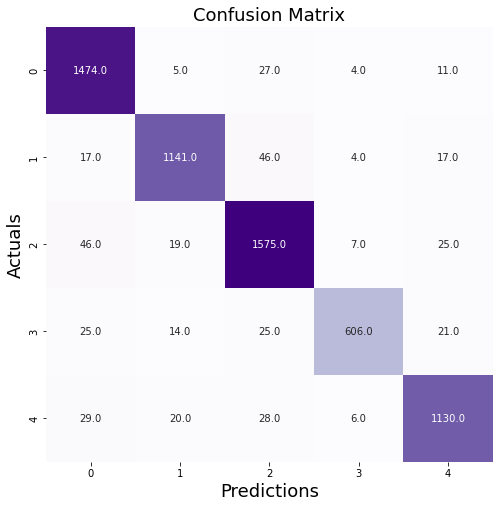

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                 annot=True,
                 cbar=False,
                 cmap="Purples", fmt = '0.1f')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification Report

In [65]:
category_names = ["Banking services", "Loans", "Fraudalent reporting", "Card", "Others"]

In [66]:
print(classification_report(y_test, y_pred, target_names = category_names))

                      precision    recall  f1-score   support

    Banking services       0.93      0.97      0.95      1521
               Loans       0.95      0.93      0.94      1225
Fraudalent reporting       0.93      0.94      0.93      1672
                Card       0.97      0.88      0.92       691
              Others       0.94      0.93      0.94      1213

            accuracy                           0.94      6322
           macro avg       0.94      0.93      0.94      6322
        weighted avg       0.94      0.94      0.94      6322

